### Topdown view comparison

In [151]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import math


In [152]:
# Configuration
process_all_folders = False
target_folder = ["Topdown", "Topdown45"]  # Updated folder names
base_dir = "../NormalContrast/img"           # Base directory stays the same
sort_by = "Skewness"  # Options: 'Kurtosis', 'RMS_Contrast', 'Variance', 'Skewness'
images_per_page = 4
cols_per_page = 4
valid_exts = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')


In [153]:
folders_to_process = (
    [f for f in os.listdir(base_dir)
     if os.path.isdir(os.path.join(base_dir, f)) and f.startswith("Topdown")]
    if process_all_folders else target_folder
)

results = []

for parent_folder in folders_to_process:
    parent_path = os.path.join(base_dir, parent_folder)

    # Now list subfolders inside (e.g., Topdown_Bricks, Topdown_Gravel, ...)
    subfolders = [f for f in os.listdir(parent_path)
                  if os.path.isdir(os.path.join(parent_path, f))]

    for subfolder in subfolders:
        folder_path = os.path.join(parent_path, subfolder)
        for fname in sorted(os.listdir(folder_path)):
            if fname.lower().endswith(valid_exts) and fname.startswith("Topdown_"):
                path = os.path.join(folder_path, fname)

                img_bgr = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                if img_bgr is None:
                    continue
                if img_bgr.dtype == np.uint16:
                    img_bgr = (img_bgr / 256).astype(np.uint8)

                gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32)
                mean = gray.mean()
                std = gray.std()
                rms = std / mean if mean > 0 else 0
                var = np.var(gray)
                sk = skew(gray.ravel())
                kurt_val = kurtosis(gray.ravel())

                results.append({
                    "folder": f"{parent_folder}/{subfolder}",
                    "filename": fname,
                    "RMS_Contrast": rms,
                    "Variance": var,
                    "Skewness": sk,
                    "Kurtosis": kurt_val,
                    "gray": gray,
                    "RGB": cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
                })

print(f"✅ Loaded {len(results)} images from nested folders")


✅ Loaded 80 images from nested folders


In [154]:
from collections import defaultdict
import re

brick_images = [r for r in results if "Topdown/Topdown_Bricks" in r["folder"]]

resolution_groups = defaultdict(list)
for r in brick_images:
    match = re.search(r'Topdown_(\d+)', r['filename'])
    if match:
        resolution = match.group(1)
        resolution_groups[resolution].append(r)


📏 Plotting resolution 1024 — 4 images


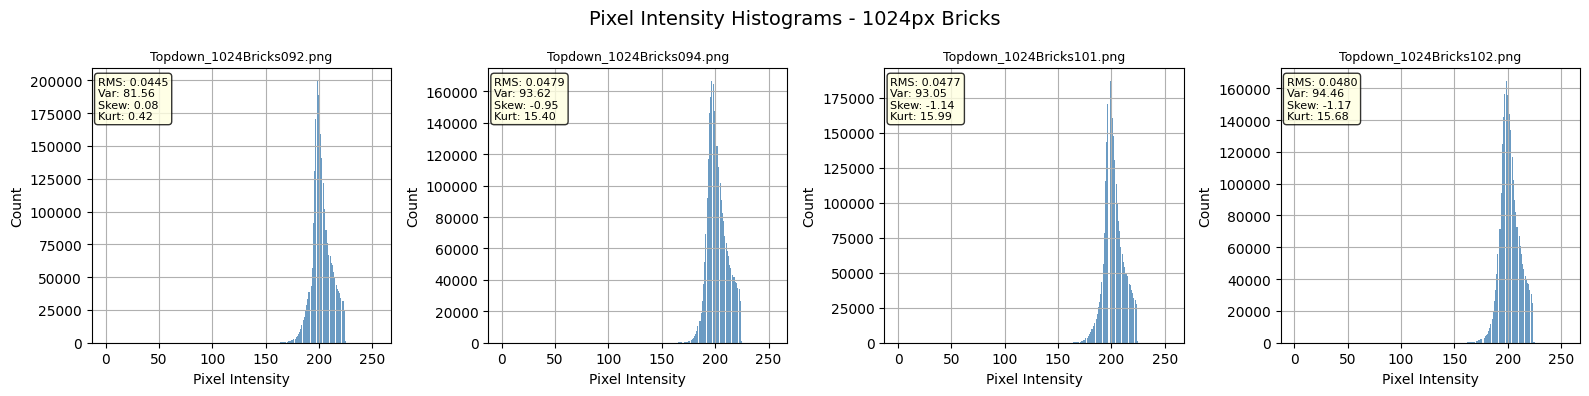

Filename  RMS_Contrast   Variance  Skewness   Kurtosis
0  Topdown_1024Bricks092.png      0.044523  81.556389  0.075808   0.418519
1  Topdown_1024Bricks094.png      0.047857  93.615860 -0.946637  15.397835
2  Topdown_1024Bricks101.png      0.047664  93.052505 -1.144038  15.987173
3  Topdown_1024Bricks102.png      0.048030  94.457047 -1.166261  15.683811

📏 Plotting resolution 512 — 4 images


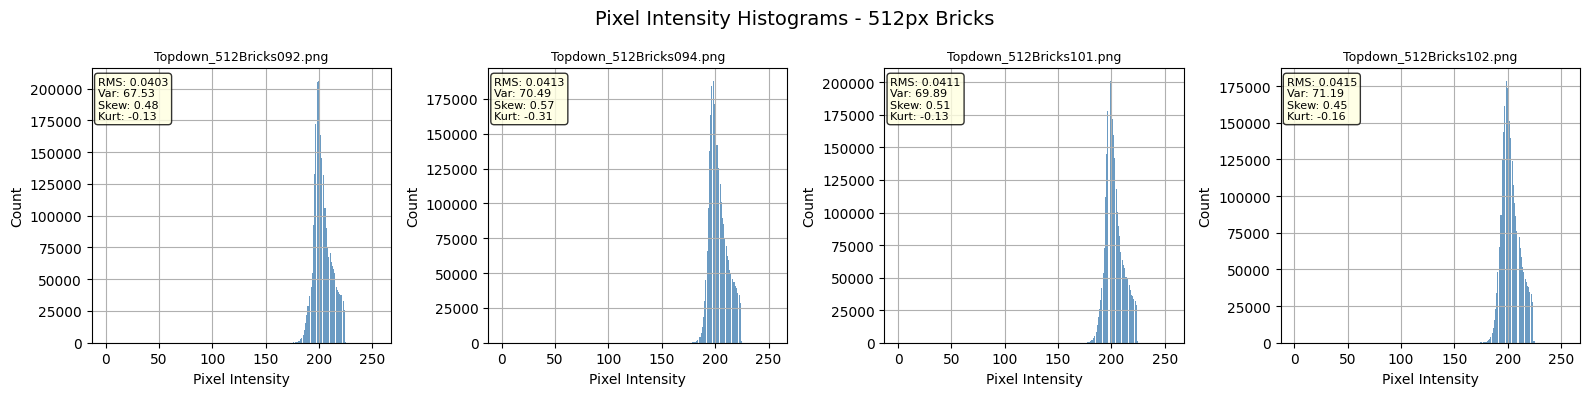

Filename  RMS_Contrast   Variance  Skewness  Kurtosis
0  Topdown_512Bricks092.png      0.040350  67.532768  0.484863 -0.130244
1  Topdown_512Bricks094.png      0.041283  70.487411  0.567564 -0.305481
2  Topdown_512Bricks101.png      0.041138  69.885590  0.509493 -0.133199
3  Topdown_512Bricks102.png      0.041494  71.185631  0.448631 -0.160462

📏 Plotting resolution 256 — 4 images


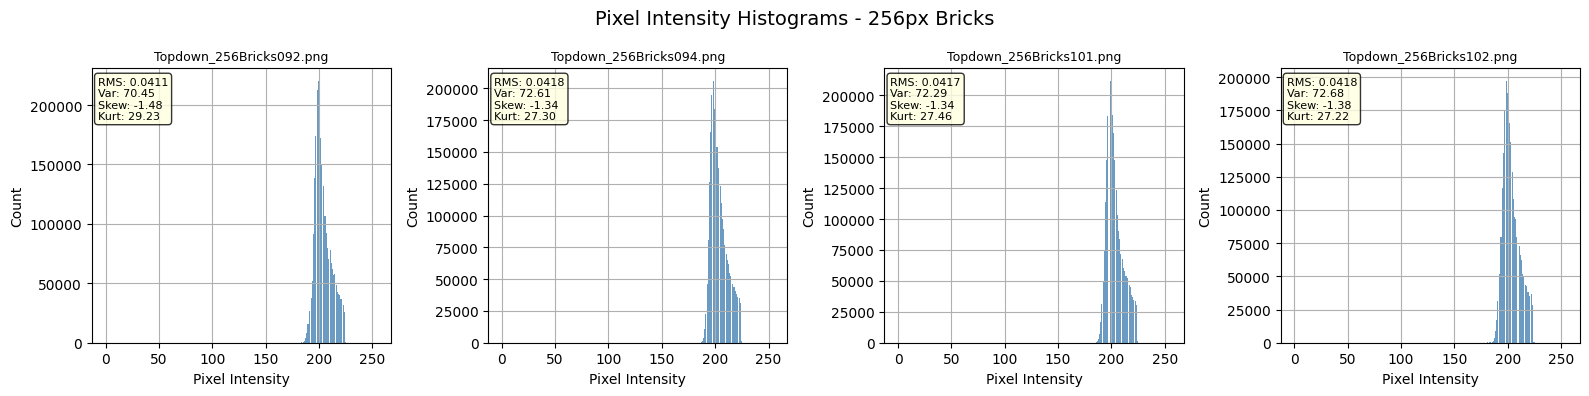

Filename  RMS_Contrast   Variance  Skewness   Kurtosis
0  Topdown_256Bricks092.png      0.041123  70.445915 -1.476788  29.225521
1  Topdown_256Bricks094.png      0.041781  72.609612 -1.340080  27.295420
2  Topdown_256Bricks101.png      0.041723  72.293678 -1.340624  27.464830
3  Topdown_256Bricks102.png      0.041815  72.684921 -1.377914  27.220051

📏 Plotting resolution 128 — 4 images


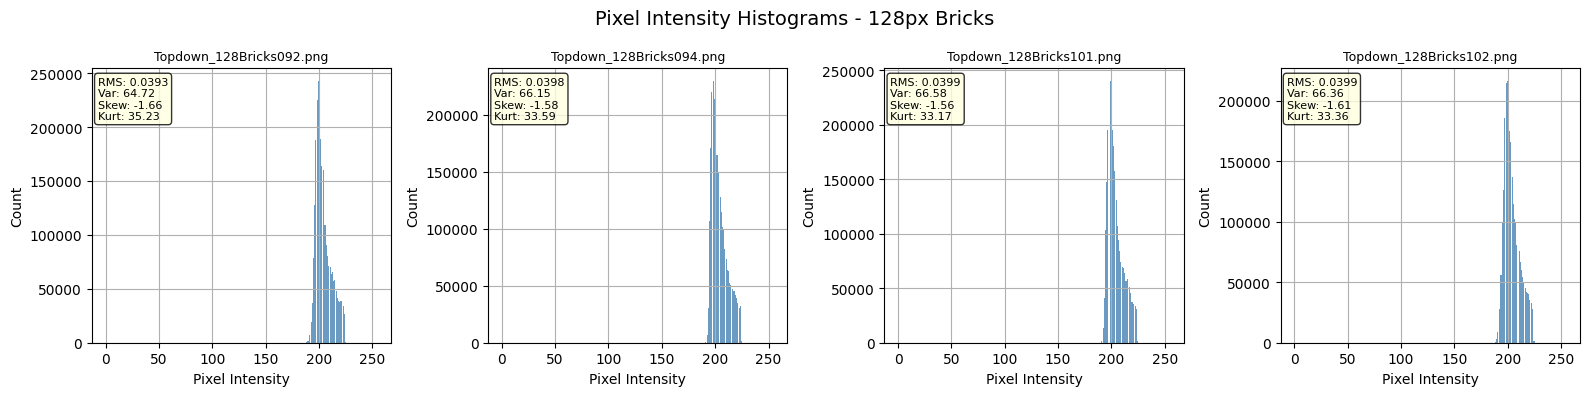

Filename  RMS_Contrast   Variance  Skewness   Kurtosis
0  Topdown_128Bricks092.png      0.039347  64.715752 -1.660543  35.229366
1  Topdown_128Bricks094.png      0.039791  66.146667 -1.576334  33.586189
2  Topdown_128Bricks101.png      0.039916  66.579666 -1.556778  33.166996
3  Topdown_128Bricks102.png      0.039859  66.357155 -1.612117  33.357643

In [190]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# Make sure `resolution_groups` is already defined, e.g. from previous filtering steps:
# resolution_groups = { "1024": [...], "512": [...], ... }

for res, group in sorted(resolution_groups.items(), key=lambda x: int(x[0]), reverse=True):
    print(f"📏 Plotting resolution {res} — {len(group)} images")

    fig, axes = plt.subplots(1, len(group), figsize=(4 * len(group), 4))
    if len(group) == 1:
        axes = [axes]

    # Plot histograms with overlay stats
    for ax, r in zip(axes, group):
        hist, bins = np.histogram(r["gray"], bins=256, range=(0, 255))
# FIXED: actual histogram bars
        ax.hist(r["gray"].ravel(), bins=256, range=(0, 255), color='steelblue', alpha=0.8)
        ax.set_title(r['filename'], fontsize=9)
        ax.set_xlabel("Pixel Intensity")
        ax.set_ylabel("Count")
        ax.grid(True)

        # Stats overlay
        ax.text(
            0.02, 0.97,
            f"RMS: {r['RMS_Contrast']:.4f}\n"
            f"Var: {r['Variance']:.2f}\n"
            f"Skew: {r['Skewness']:.2f}\n"
            f"Kurt: {r['Kurtosis']:.2f}",
            transform=ax.transAxes,
            fontsize=8,
            verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", ec="black", alpha=0.8)
        )

    fig.suptitle(f"Pixel Intensity Histograms - {res}px Bricks", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Create and display summary table
    df = pd.DataFrame([{
        "Filename": r["filename"],
        "RMS_Contrast": r["RMS_Contrast"],
        "Variance": r["Variance"],
        "Skewness": r["Skewness"],
        "Kurtosis": r["Kurtosis"]
    } for r in group])

    display(df.sort_values("Filename"))


In [ ]:
import pandas as pd
import re

# Reformat into long-table first
table_rows = []

for r in brick_images:
    # Match resolution and brick ID
    match = re.match(r"Topdown_(\d+)(Bricks\d+)\.png", r["filename"])
    if match:
        res = match.group(1)
        brick_id = match.group(2)

        table_rows.append({
            "Brick": brick_id,
            "Resolution": res,
            "RMS": r["RMS_Contrast"],
            "Variance": r["Variance"],
            "Skewness": r["Skewness"],
            "Kurtosis": r["Kurtosis"]
        })

df_long = pd.DataFrame(table_rows)


In [ ]:
# Create pivot tables for each metric
pivot_rms = df_long.pivot(index="Brick", columns="Resolution", values="RMS")
pivot_var = df_long.pivot(index="Brick", columns="Resolution", values="Variance")
pivot_skew = df_long.pivot(index="Brick", columns="Resolution", values="Skewness")
pivot_kurt = df_long.pivot(index="Brick", columns="Resolution", values="Kurtosis")

# Display all
print("🔍 RMS Contrast Comparison")
display(pivot_rms)

print("📊 Variance Comparison")
display(pivot_var)

print("↩️ Skewness Comparison")
display(pivot_skew)

print("🎯 Kurtosis Comparison")
display(pivot_kurt)


🔍 RMS Contrast Comparison


Resolution      1024       128       256       512
Brick                                             
Bricks092   0.044523  0.039347  0.041123  0.040350
Bricks094   0.047857  0.039791  0.041781  0.041283
Bricks101   0.047664  0.039916  0.041723  0.041138
Bricks102   0.048030  0.039859  0.041815  0.041494

📊 Variance Comparison


Resolution       1024        128        256        512
Brick                                                 
Bricks092   81.556389  64.715752  70.445915  67.532768
Bricks094   93.615860  66.146667  72.609612  70.487411
Bricks101   93.052505  66.579666  72.293678  69.885590
Bricks102   94.457047  66.357155  72.684921  71.185631

↩️ Skewness Comparison


Resolution      1024       128       256       512
Brick                                             
Bricks092   0.075808 -1.660543 -1.476788  0.484863
Bricks094  -0.946637 -1.576334 -1.340080  0.567564
Bricks101  -1.144038 -1.556778 -1.340624  0.509493
Bricks102  -1.166261 -1.612117 -1.377914  0.448631

🎯 Kurtosis Comparison


Resolution       1024        128        256       512
Brick                                                
Bricks092    0.418519  35.229366  29.225521 -0.130244
Bricks094   15.397835  33.586189  27.295420 -0.305481
Bricks101   15.987173  33.166996  27.464830 -0.133199
Bricks102   15.683811  33.357643  27.220051 -0.160462

In [ ]:
from collections import defaultdict

# Organize images: {brick_id: {resolution: image_data}}
brick_img_dict = defaultdict(dict)

for r in brick_images:
    match = re.match(r"Topdown_(\d+)(Bricks\d+)\.png", r["filename"])
    if match:
        res = match.group(1)
        brick_id = match.group(2)
        brick_img_dict[brick_id][res] = r


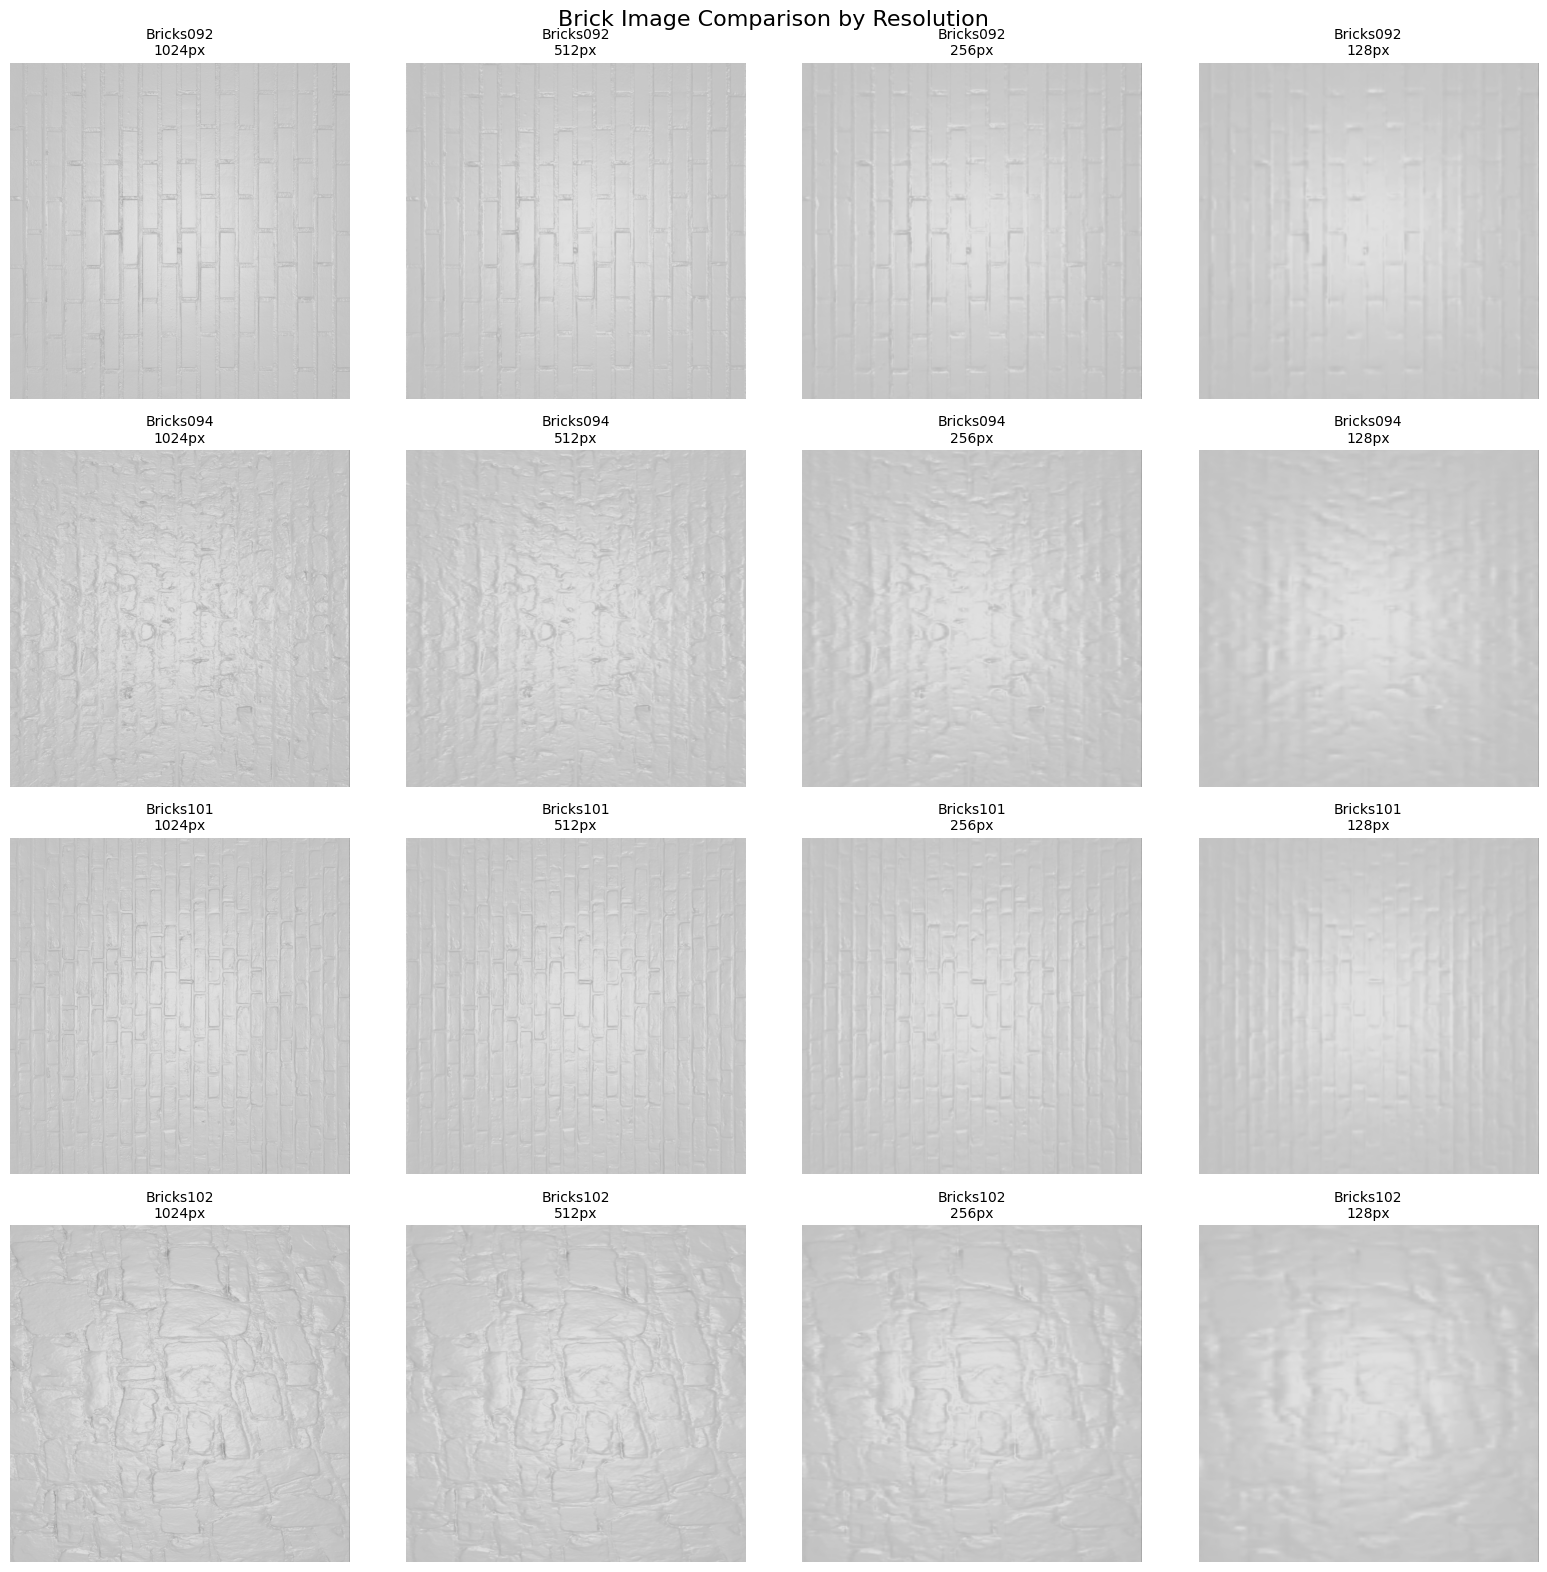

In [ ]:
# Sort for consistent layout
sorted_bricks = sorted(brick_img_dict.keys())
sorted_resolutions = sorted({res for imgs in brick_img_dict.values() for res in imgs.keys()}, key=int, reverse=True)

# Plot
fig, axes = plt.subplots(len(sorted_bricks), len(sorted_resolutions), figsize=(4 * len(sorted_resolutions), 4 * len(sorted_bricks)))

for row_idx, brick_id in enumerate(sorted_bricks):
    for col_idx, res in enumerate(sorted_resolutions):
        ax = axes[row_idx, col_idx] if len(sorted_bricks) > 1 else axes[col_idx]
        r = brick_img_dict[brick_id].get(res, None)

        if r:
            ax.imshow(r["RGB"])
            ax.set_title(f"{brick_id}\n{res}px", fontsize=10)
        else:
            ax.text(0.5, 0.5, "Missing", ha="center", va="center")
        ax.axis("off")

plt.suptitle("Brick Image Comparison by Resolution", fontsize=16)
plt.tight_layout()
plt.show()

### Topdown45 view Comparison

In [ ]:
brick45_images = []

base_dir_45 = "../NormalContrast/img/Topdown45/Topdown45_Bricks"  # Adjust path as needed

for fname in sorted(os.listdir(base_dir_45)):
    if fname.lower().endswith(valid_exts) and fname.lower().startswith("topdown45_"):
        path = os.path.join(base_dir_45, fname)
        img_bgr = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        if img_bgr is None:
            continue
        if img_bgr.dtype == np.uint16:
            img_bgr = (img_bgr / 256).astype(np.uint8)

        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32)
        mean = gray.mean()
        std = gray.std()
        rms = std / mean if mean > 0 else 0
        var = np.var(gray)
        sk = skew(gray.ravel())
        kurt_val = kurtosis(gray.ravel())

        brick45_images.append({
            "folder": "Topdown45/Topdown45_Bricks",
            "filename": fname,
            "RMS_Contrast": rms,
            "Variance": var,
            "Skewness": sk,
            "Kurtosis": kurt_val,
            "gray": gray,
            "RGB": cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        })

print(f"✅ Loaded {len(brick45_images)} images from Topdown45/Topdown45_Bricks")


✅ Loaded 16 images from Topdown45/Topdown45_Bricks


In [ ]:
brick45_images = []

base_dir_45 = "../NormalContrast/img/Topdown45/Topdown45_Bricks"

for fname in sorted(os.listdir(base_dir_45)):
    if fname.lower().endswith(valid_exts) and fname.lower().startswith("topdown45_"):
        path = os.path.join(base_dir_45, fname)
        img_bgr = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        if img_bgr is None:
            continue
        if img_bgr.dtype == np.uint16:
            img_bgr = (img_bgr / 256).astype(np.uint8)

        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32)
        mean = gray.mean()
        std = gray.std()
        rms = std / mean if mean > 0 else 0
        var = np.var(gray)
        sk = skew(gray.ravel())
        kurt_val = kurtosis(gray.ravel())

        brick45_images.append({
            "folder": "Topdown45/Topdown45_Bricks",
            "filename": fname,
            "RMS_Contrast": rms,
            "Variance": var,
            "Skewness": sk,
            "Kurtosis": kurt_val,
            "gray": gray,
            "RGB": cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        })

print(f"✅ Loaded {len(brick45_images)} images from Topdown45/Topdown45_Bricks")


✅ Loaded 16 images from Topdown45/Topdown45_Bricks


In [ ]:
from collections import defaultdict
import re

resolution_groups_45 = defaultdict(list)

for r in brick45_images:
    match = re.match(r"topdown45_(\d+)", r["filename"], re.IGNORECASE)
    if match:
        resolution = match.group(1)
        resolution_groups_45[resolution].append(r)


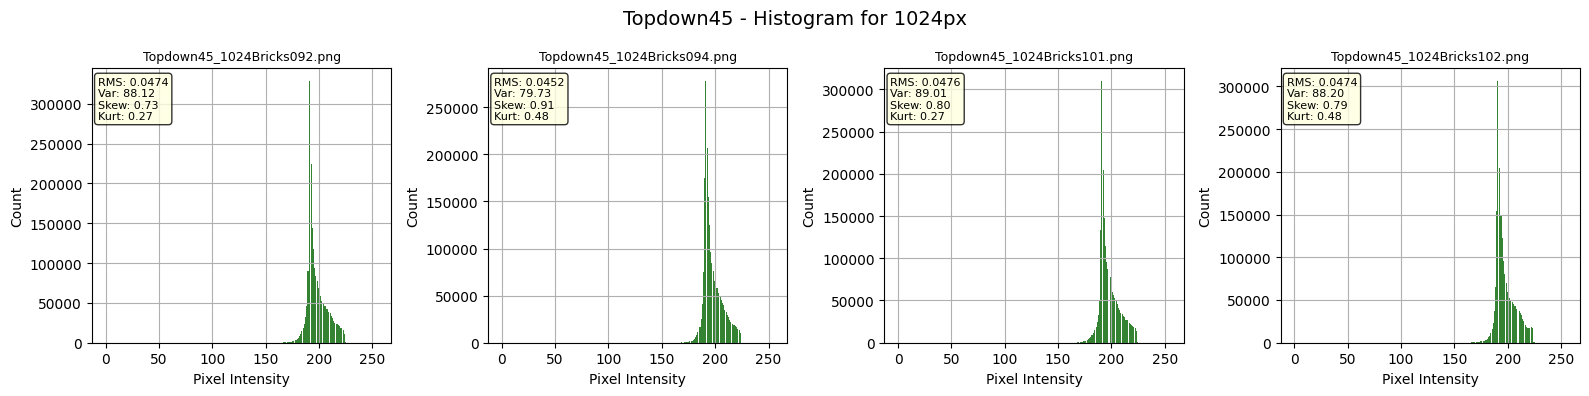

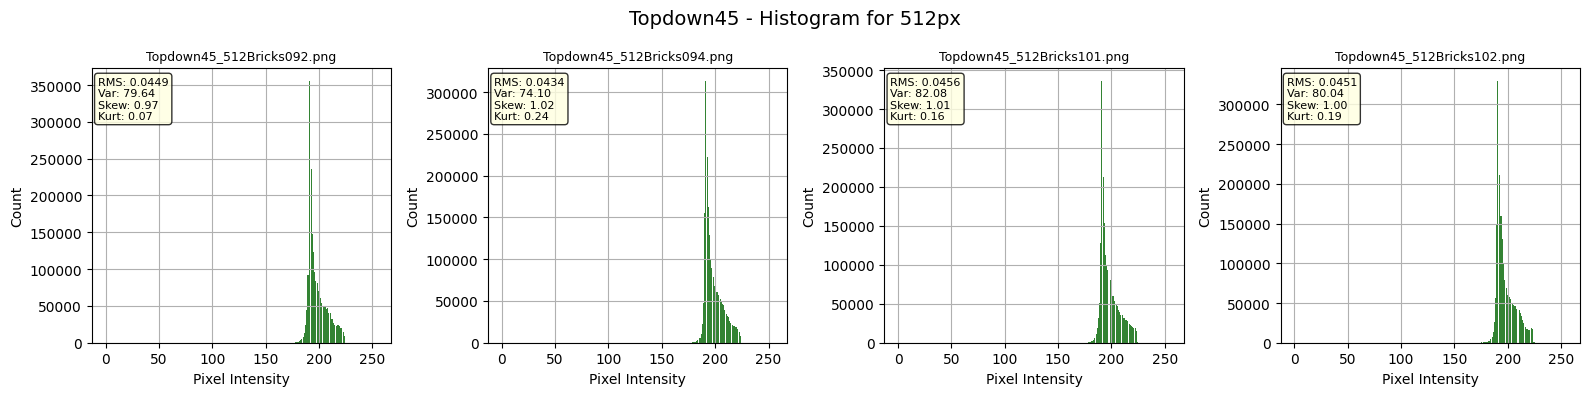

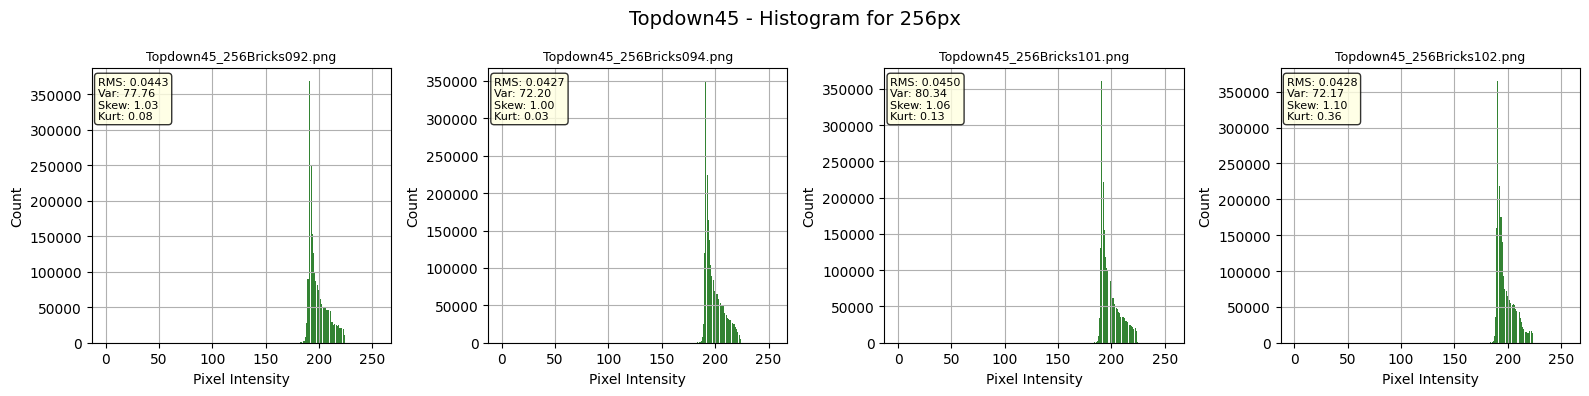

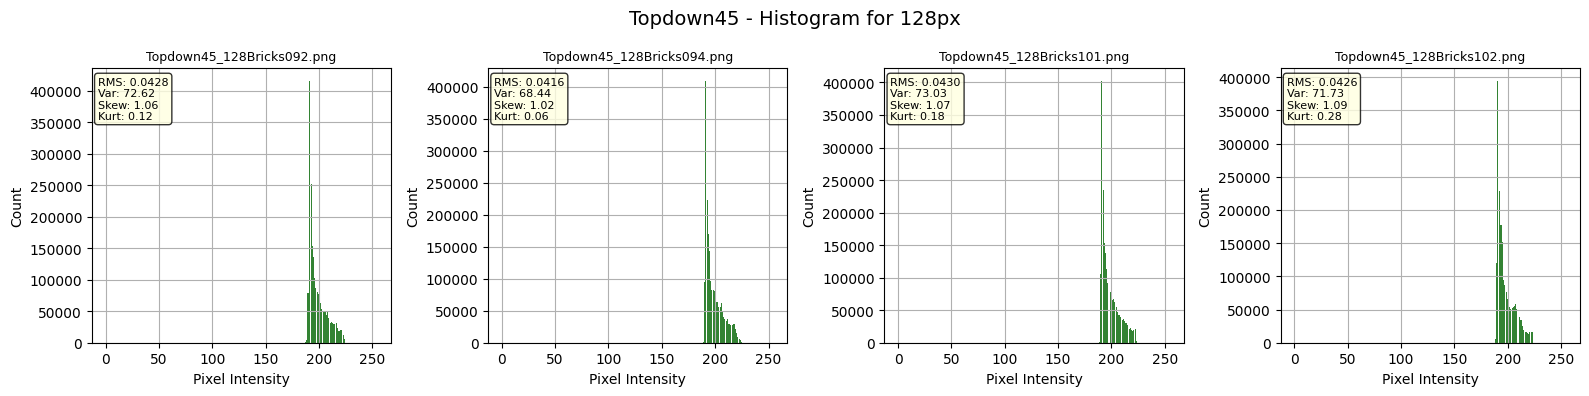

In [191]:
for res, group in sorted(resolution_groups_45.items(), key=lambda x: int(x[0]), reverse=True):
    fig, axes = plt.subplots(1, len(group), figsize=(4 * len(group), 4))
    if len(group) == 1:
        axes = [axes]

    for ax, r in zip(axes, group):
        hist, bins = np.histogram(r["gray"], bins=256, range=(0, 255))
# FIXED: actual histogram bars
        ax.hist(r["gray"].ravel(), bins=256, range=(0, 255), color='darkgreen', alpha=0.8)
        ax.set_title(r['filename'], fontsize=9)
        ax.set_xlabel("Pixel Intensity")
        ax.set_ylabel("Count")
        ax.grid(True)

        ax.text(
            0.02, 0.97,
            f"RMS: {r['RMS_Contrast']:.4f}\n"
            f"Var: {r['Variance']:.2f}\n"
            f"Skew: {r['Skewness']:.2f}\n"
            f"Kurt: {r['Kurtosis']:.2f}",
            transform=ax.transAxes,
            fontsize=8,
            verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", ec="black", alpha=0.8)
        )

    fig.suptitle(f"Topdown45 - Histogram for {res}px", fontsize=14)
    plt.tight_layout()
    plt.show()


In [ ]:
# Build long table
table_rows_45 = []

for r in brick45_images:
    match = re.match(r"topdown45_(\d+)(Bricks\d+)\.png", r["filename"], re.IGNORECASE)
    if match:
        res = match.group(1)
        brick_id = match.group(2)

        table_rows_45.append({
            "Brick": brick_id,
            "Resolution": res,
            "RMS": r["RMS_Contrast"],
            "Variance": r["Variance"],
            "Skewness": r["Skewness"],
            "Kurtosis": r["Kurtosis"]
        })

df45_long = pd.DataFrame(table_rows_45)


In [ ]:
pivot_rms_45 = df45_long.pivot(index="Brick", columns="Resolution", values="RMS")
pivot_var_45 = df45_long.pivot(index="Brick", columns="Resolution", values="Variance")
pivot_skew_45 = df45_long.pivot(index="Brick", columns="Resolution", values="Skewness")
pivot_kurt_45 = df45_long.pivot(index="Brick", columns="Resolution", values="Kurtosis")

print("🔍 RMS Contrast Comparison (Topdown45)")
display(pivot_rms_45)

print("📊 Variance Comparison (Topdown45)")
display(pivot_var_45)

print("↩️ Skewness Comparison (Topdown45)")
display(pivot_skew_45)

print("🎯 Kurtosis Comparison (Topdown45)")
display(pivot_kurt_45)


🔍 RMS Contrast Comparison (Topdown45)


Resolution      1024       128       256       512
Brick                                             
Bricks092   0.047362  0.042836  0.044289  0.044903
Bricks094   0.045176  0.041608  0.042717  0.043384
Bricks101   0.047642  0.042959  0.045039  0.045630
Bricks102   0.047440  0.042610  0.042813  0.045071

📊 Variance Comparison (Topdown45)


Resolution       1024        128        256        512
Brick                                                 
Bricks092   88.115776  72.620468  77.762794  79.642204
Bricks094   79.729958  68.441025  72.196838  74.097702
Bricks101   89.010857  73.026855  80.343475  82.083023
Bricks102   88.199577  71.727432  72.170868  80.043777

↩️ Skewness Comparison (Topdown45)


Resolution      1024       128       256       512
Brick                                             
Bricks092   0.730584  1.058585  1.027370  0.968550
Bricks094   0.906548  1.020941  0.998058  1.020147
Bricks101   0.795624  1.072450  1.058099  1.007388
Bricks102   0.791086  1.085937  1.096469  0.996050

🎯 Kurtosis Comparison (Topdown45)


Resolution      1024       128       256       512
Brick                                             
Bricks092   0.271305  0.119598  0.083126  0.074889
Bricks094   0.481112  0.064775  0.028989  0.236479
Bricks101   0.274967  0.180163  0.129005  0.162531
Bricks102   0.478453  0.284460  0.356403  0.190705

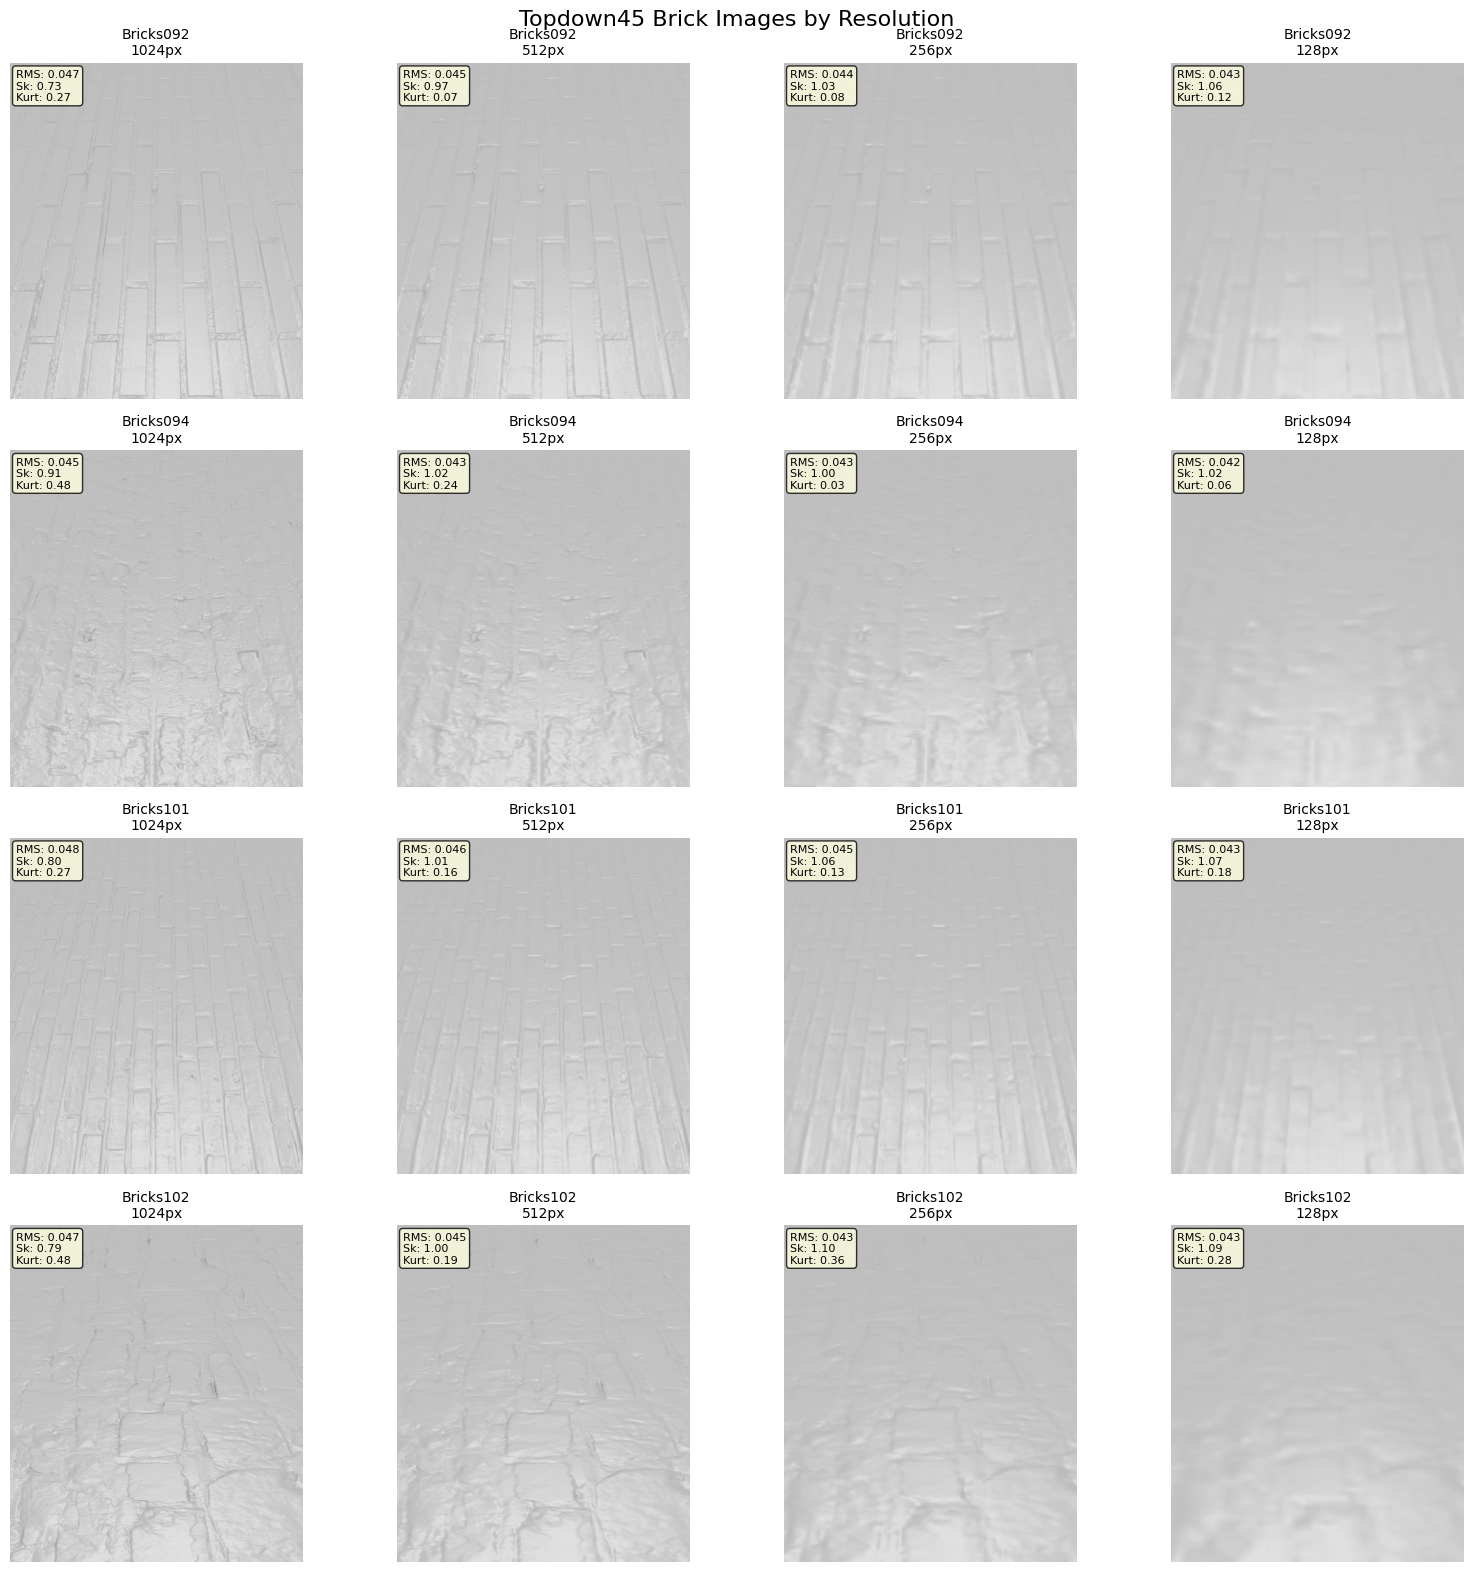

In [ ]:
brick_img_dict_45 = defaultdict(dict)

for r in brick45_images:
    match = re.match(r"topdown45_(\d+)(Bricks\d+)\.png", r["filename"], re.IGNORECASE)
    if match:
        res = match.group(1)
        brick_id = match.group(2)
        brick_img_dict_45[brick_id][res] = r

sorted_bricks_45 = sorted(brick_img_dict_45.keys())
sorted_resolutions_45 = sorted({res for imgs in brick_img_dict_45.values() for res in imgs.keys()}, key=int, reverse=True)

fig, axes = plt.subplots(len(sorted_bricks_45), len(sorted_resolutions_45), figsize=(4 * len(sorted_resolutions_45), 4 * len(sorted_bricks_45)))

for row_idx, brick_id in enumerate(sorted_bricks_45):
    for col_idx, res in enumerate(sorted_resolutions_45):
        ax = axes[row_idx, col_idx] if len(sorted_bricks_45) > 1 else axes[col_idx]
        r = brick_img_dict_45[brick_id].get(res, None)

        if r:
            ax.imshow(r["RGB"])
            ax.set_title(f"{brick_id}\n{res}px", fontsize=10)

            # Optional: overlay metrics
            stats_text = (
                f"RMS: {r['RMS_Contrast']:.3f}\n"
                f"Sk: {r['Skewness']:.2f}\n"
                f"Kurt: {r['Kurtosis']:.2f}"
            )
            ax.text(
                0.02, 0.98,
                stats_text,
                transform=ax.transAxes,
                fontsize=8,
                verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", ec="black", alpha=0.8)
            )
        else:
            ax.text(0.5, 0.5, "Missing", ha="center", va="center")
        ax.axis("off")

plt.suptitle("Topdown45 Brick Images by Resolution", fontsize=16)
plt.tight_layout()
plt.show()


### Side by side

In [ ]:
import pandas as pd
import re

# === STEP 1: Build Combined DataFrame ===
combined_rows = []

# Topdown
for r in brick_images:
    match = re.match(r"Topdown_(\d+)(Bricks\d+)\.png", r["filename"])
    if match:
        res = int(match.group(1))  # convert to int
        brick_id = match.group(2)
        combined_rows.append({
            "Brick": brick_id,
            "Resolution": res,
            "View": "Topdown",
            "RMS": r["RMS_Contrast"],
            "Variance": r["Variance"],
            "Skewness": r["Skewness"],
            "Kurtosis": r["Kurtosis"]
        })

# Topdown45
for r in brick45_images:
    match = re.match(r"topdown45_(\d+)(Bricks\d+)\.png", r["filename"], re.IGNORECASE)
    if match:
        res = int(match.group(1))  # convert to int
        brick_id = match.group(2)
        combined_rows.append({
            "Brick": brick_id,
            "Resolution": res,
            "View": "Topdown45",
            "RMS": r["RMS_Contrast"],
            "Variance": r["Variance"],
            "Skewness": r["Skewness"],
            "Kurtosis": r["Kurtosis"]
        })

df_combined = pd.DataFrame(combined_rows)

In [ ]:

pivot_rms = df_combined.pivot(index=["Brick", "Resolution"], columns="View", values="RMS")
pivot_rms = pivot_rms.sort_index(level="Resolution", ascending=False)

pivot_var = df_combined.pivot(index=["Brick", "Resolution"], columns="View", values="Variance")
pivot_var = pivot_var.sort_index(level="Resolution", ascending=False)

pivot_skew = df_combined.pivot(index=["Brick", "Resolution"], columns="View", values="Skewness")
pivot_skew = pivot_skew.sort_index(level="Resolution", ascending=False)

pivot_kurt = df_combined.pivot(index=["Brick", "Resolution"], columns="View", values="Kurtosis")
pivot_kurt = pivot_kurt.sort_index(level="Resolution", ascending=False)

# === STEP 3: Display ===
print("🔍 RMS Contrast Comparison")
display(pivot_rms)

print("📊 Variance Comparison")
display(pivot_var)

print("↩️ Skewness Comparison")
display(pivot_skew)

print("🎯 Kurtosis Comparison")
display(pivot_kurt)

🔍 RMS Contrast Comparison


View                   Topdown  Topdown45
Brick     Resolution                     
Bricks102 1024        0.048030   0.047440
Bricks101 1024        0.047664   0.047642
Bricks094 1024        0.047857   0.045176
Bricks092 1024        0.044523   0.047362
Bricks102 512         0.041494   0.045071
Bricks101 512         0.041138   0.045630
Bricks094 512         0.041283   0.043384
Bricks092 512         0.040350   0.044903
Bricks102 256         0.041815   0.042813
Bricks101 256         0.041723   0.045039
Bricks094 256         0.041781   0.042717
Bricks092 256         0.041123   0.044289
Bricks102 128         0.039859   0.042610
Bricks101 128         0.039916   0.042959
Bricks094 128         0.039791   0.041608
Bricks092 128         0.039347   0.042836

📊 Variance Comparison


View                    Topdown  Topdown45
Brick     Resolution                      
Bricks102 1024        94.457047  88.199577
Bricks101 1024        93.052505  89.010857
Bricks094 1024        93.615860  79.729958
Bricks092 1024        81.556389  88.115776
Bricks102 512         71.185631  80.043777
Bricks101 512         69.885590  82.083023
Bricks094 512         70.487411  74.097702
Bricks092 512         67.532768  79.642204
Bricks102 256         72.684921  72.170868
Bricks101 256         72.293678  80.343475
Bricks094 256         72.609612  72.196838
Bricks092 256         70.445915  77.762794
Bricks102 128         66.357155  71.727432
Bricks101 128         66.579666  73.026855
Bricks094 128         66.146667  68.441025
Bricks092 128         64.715752  72.620468

↩️ Skewness Comparison


View                   Topdown  Topdown45
Brick     Resolution                     
Bricks102 1024       -1.166261   0.791086
Bricks101 1024       -1.144038   0.795624
Bricks094 1024       -0.946637   0.906548
Bricks092 1024        0.075808   0.730584
Bricks102 512         0.448631   0.996050
Bricks101 512         0.509493   1.007388
Bricks094 512         0.567564   1.020147
Bricks092 512         0.484863   0.968550
Bricks102 256        -1.377914   1.096469
Bricks101 256        -1.340624   1.058099
Bricks094 256        -1.340080   0.998058
Bricks092 256        -1.476788   1.027370
Bricks102 128        -1.612117   1.085937
Bricks101 128        -1.556778   1.072450
Bricks094 128        -1.576334   1.020941
Bricks092 128        -1.660543   1.058585

🎯 Kurtosis Comparison


View                    Topdown  Topdown45
Brick     Resolution                      
Bricks102 1024        15.683811   0.478453
Bricks101 1024        15.987173   0.274967
Bricks094 1024        15.397835   0.481112
Bricks092 1024         0.418519   0.271305
Bricks102 512         -0.160462   0.190705
Bricks101 512         -0.133199   0.162531
Bricks094 512         -0.305481   0.236479
Bricks092 512         -0.130244   0.074889
Bricks102 256         27.220051   0.356403
Bricks101 256         27.464830   0.129005
Bricks094 256         27.295420   0.028989
Bricks092 256         29.225521   0.083126
Bricks102 128         33.357643   0.284460
Bricks101 128         33.166996   0.180163
Bricks094 128         33.586189   0.064775
Bricks092 128         35.229366   0.119598

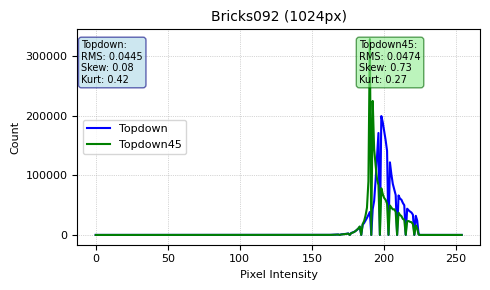

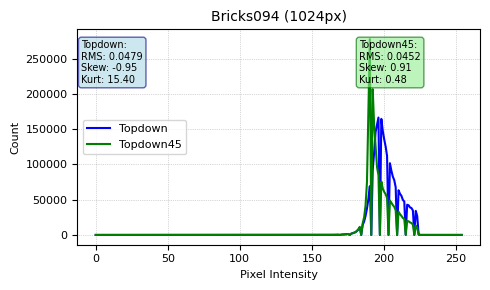

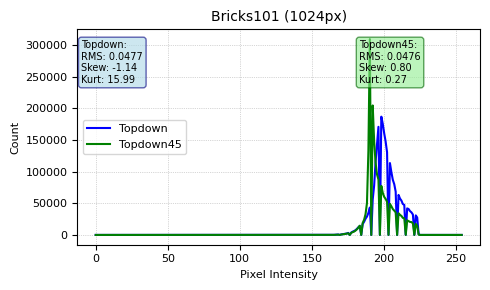

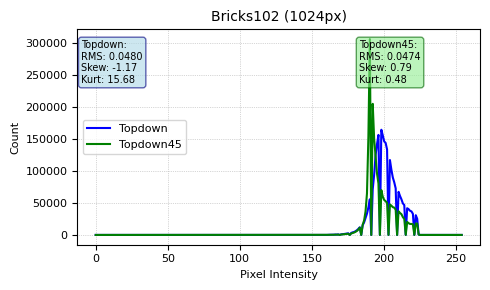

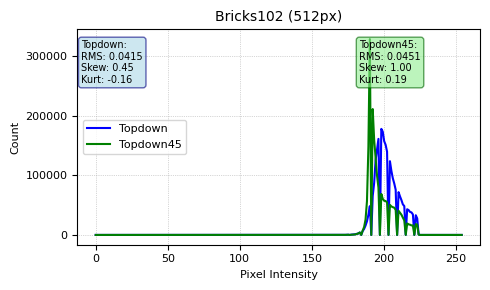

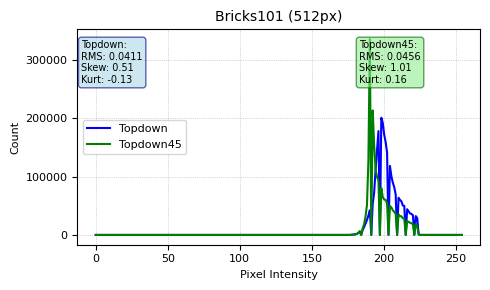

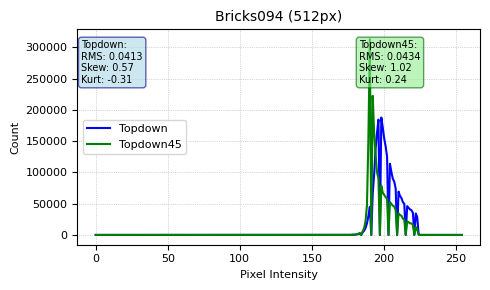

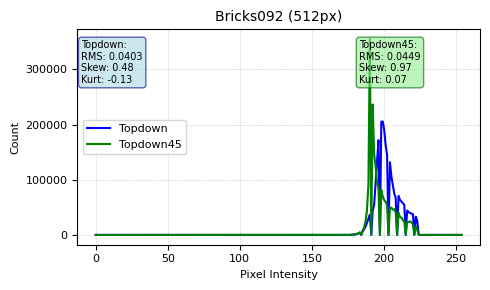

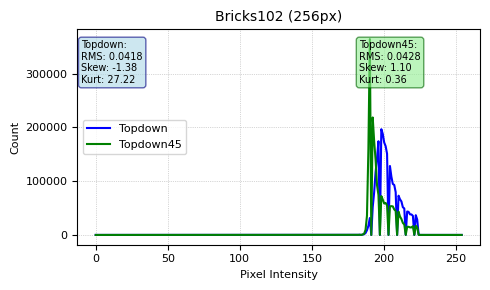

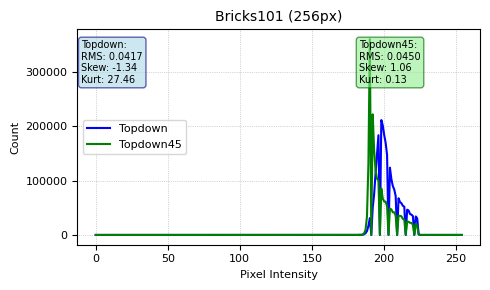

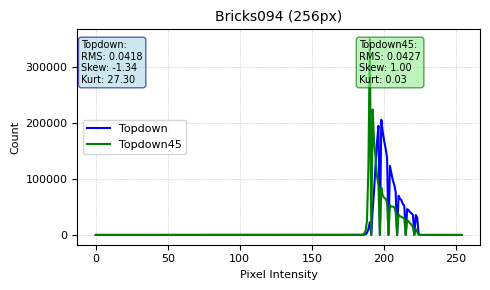

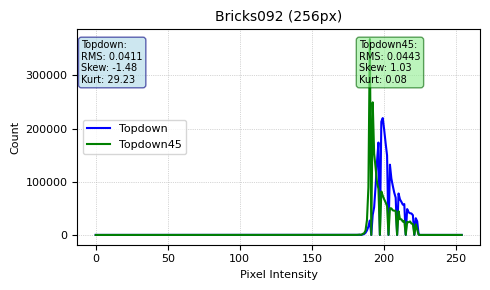

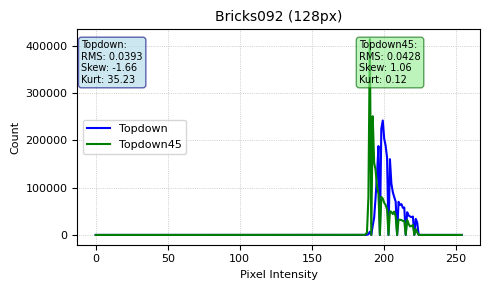

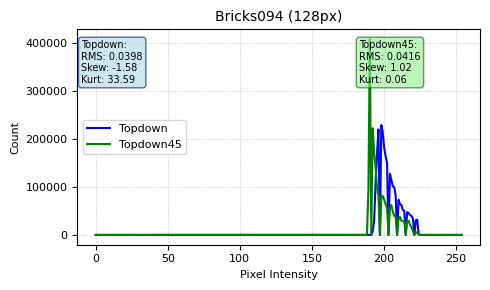

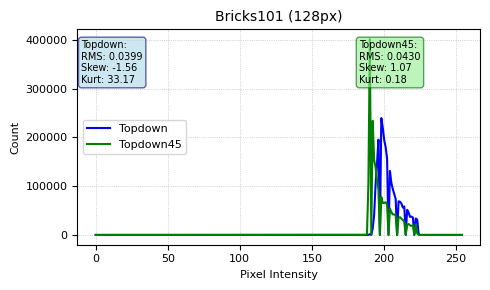

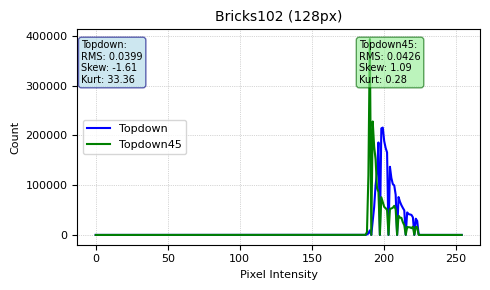

In [ ]:
# Make sure 'Resolution' is integer and sorted descending
df_combined["Resolution"] = df_combined["Resolution"].astype(int)

# Unique brick-res pairs in desired order (by descending resolution)
plot_order = df_combined.sort_values(by="Resolution", ascending=False)[["Brick", "Resolution"]].drop_duplicates()


for _, row in plot_order.iterrows():
    brick = row["Brick"]
    res = row["Resolution"]

    # Match filenames using resolution and brick
    img_top = next((r for r in brick_images if brick in r["filename"] and f"_{res}" in r["filename"]), None)
    img_45 = next((r for r in brick45_images if brick in r["filename"] and f"_{res}" in r["filename"]), None)

    if img_top and img_45:
        gray1 = img_top["gray"]
        gray2 = img_45["gray"]

        hist1, bins = np.histogram(gray1, bins=256, range=(0, 255))
        hist2, _ = np.histogram(gray2, bins=256, range=(0, 255))

        plt.figure(figsize=(5, 3))
        plt.plot(bins[:-1], hist1, label='Topdown', color='blue')
        plt.plot(bins[:-1], hist2, label='Topdown45', color='green')
        plt.title(f"{brick} ({res}px)", fontsize=10)
        plt.xlabel("Pixel Intensity", fontsize=8)
        plt.ylabel("Count", fontsize=8)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        plt.legend(fontsize=8)
        plt.grid(True, linestyle=':', linewidth=0.5)

        # === Overlay stats box ===
        stats_top = (
            f"Topdown:\n"
            f"RMS: {img_top['RMS_Contrast']:.4f}\n"
            f"Skew: {img_top['Skewness']:.2f}\n"
            f"Kurt: {img_top['Kurtosis']:.2f}"
        )
        stats_45 = (
            f"Topdown45:\n"
            f"RMS: {img_45['RMS_Contrast']:.4f}\n"
            f"Skew: {img_45['Skewness']:.2f}\n"
            f"Kurt: {img_45['Kurtosis']:.2f}"
        )

        # Draw two stat boxes
        plt.text(
            0.01, 0.95, stats_top,
            transform=plt.gca().transAxes,
            fontsize=7, va='top',
            bbox=dict(boxstyle="round,pad=0.3", fc="lightblue", ec="navy", alpha=0.6)
        )

        plt.text(
            0.70, 0.95, stats_45,
            transform=plt.gca().transAxes,
            fontsize=7, va='top',
            bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen", ec="darkgreen", alpha=0.6)
        )

        plt.tight_layout()
        plt.show()




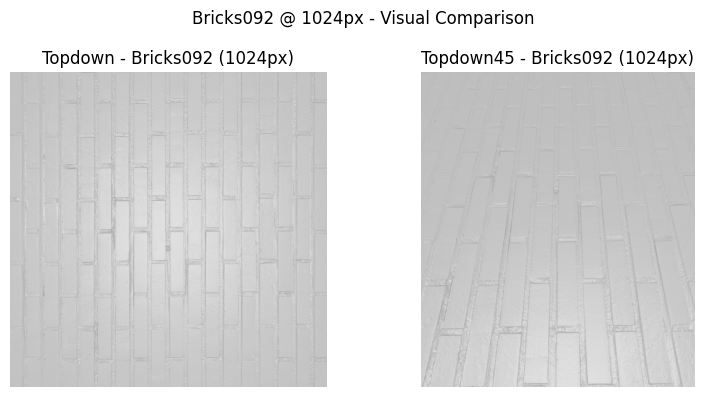

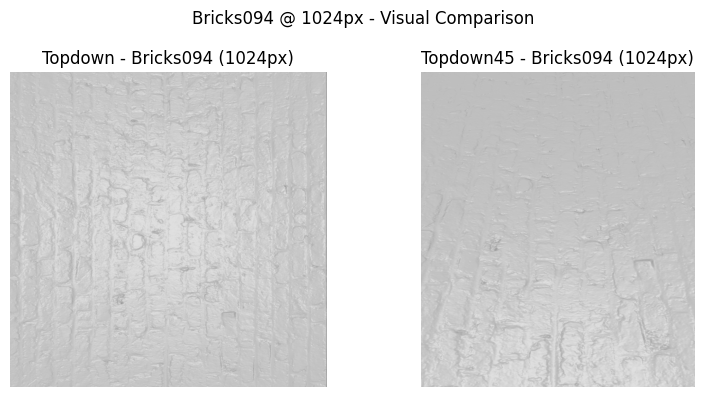

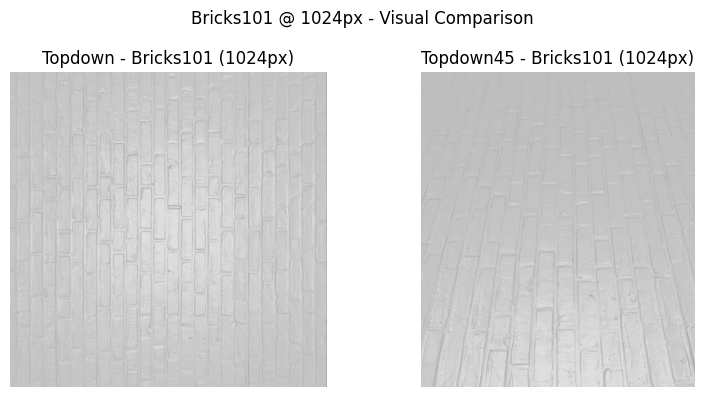

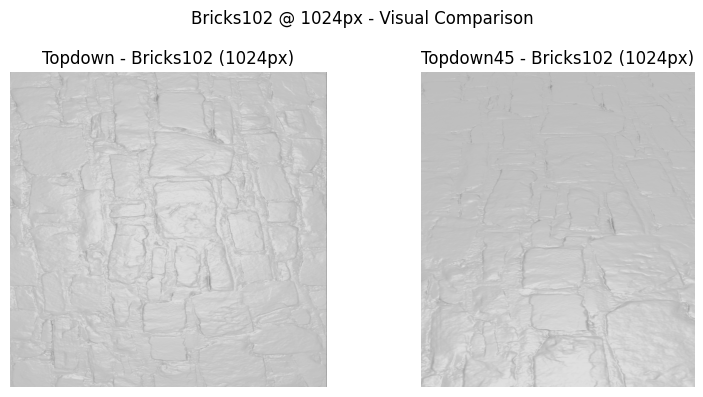

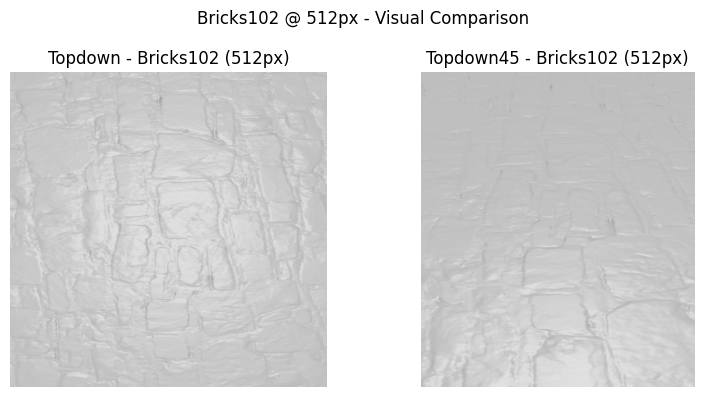

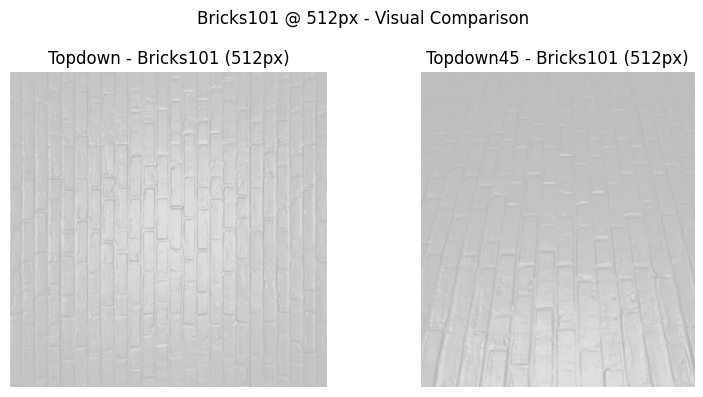

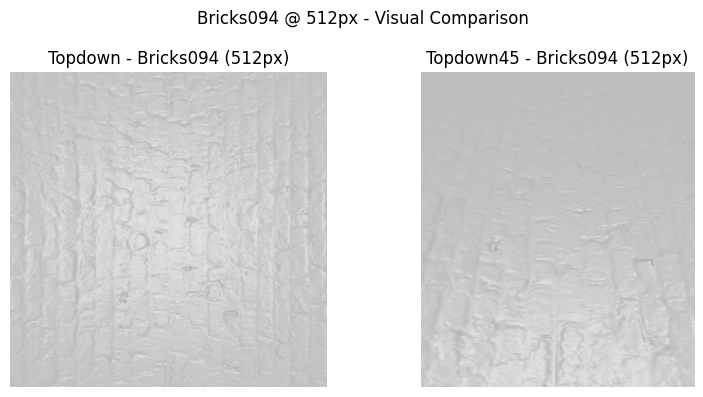

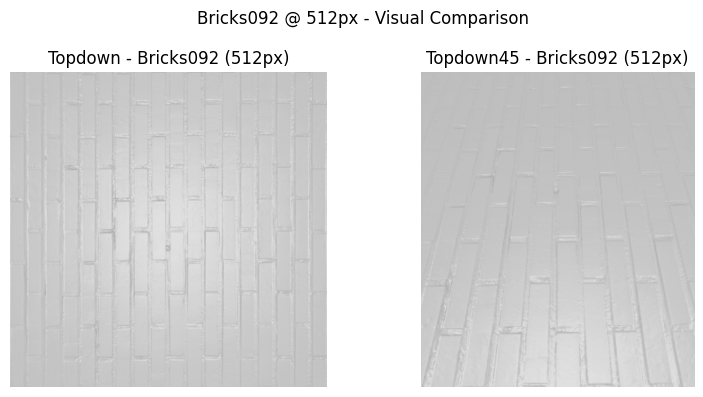

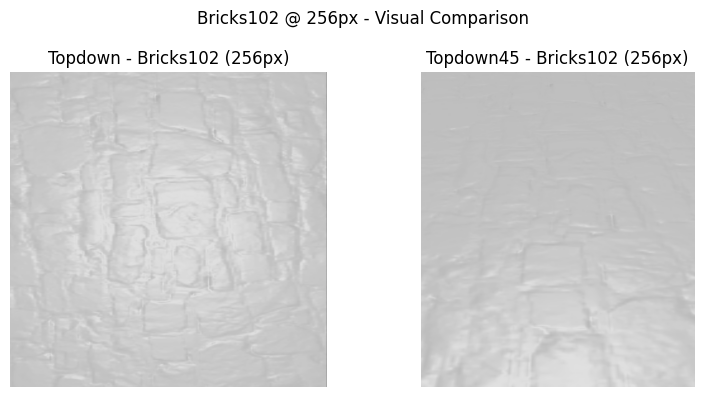

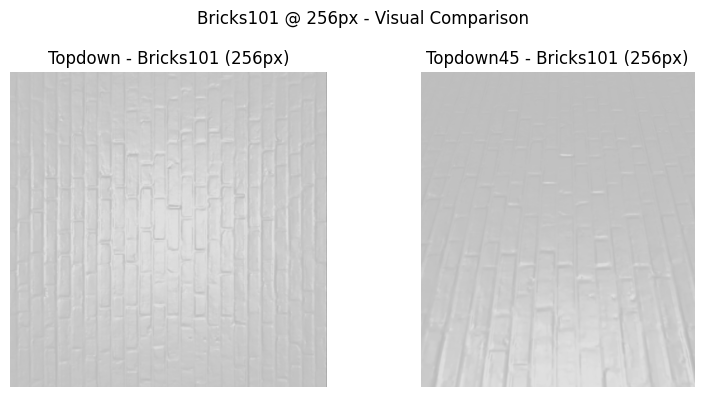

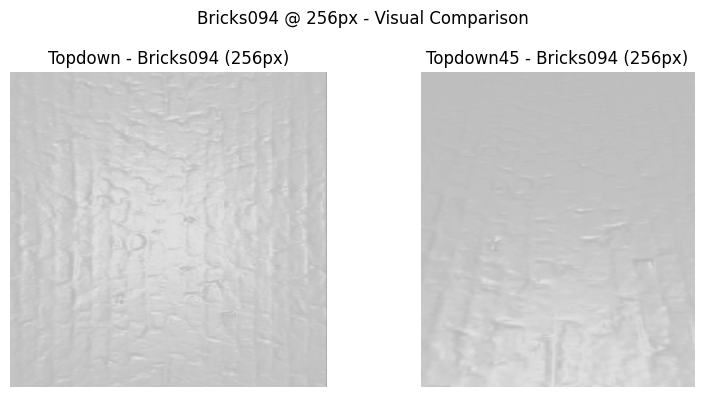

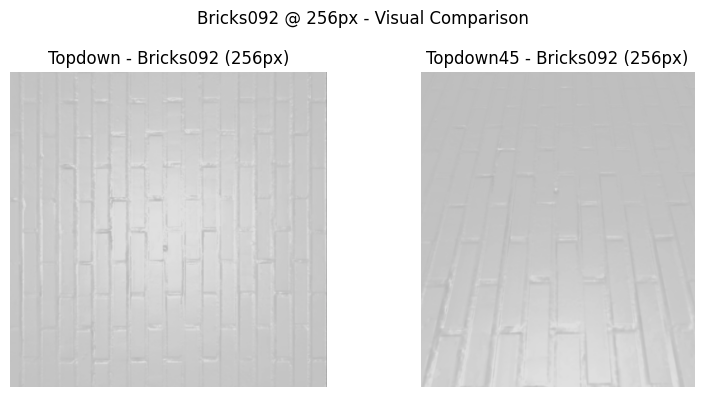

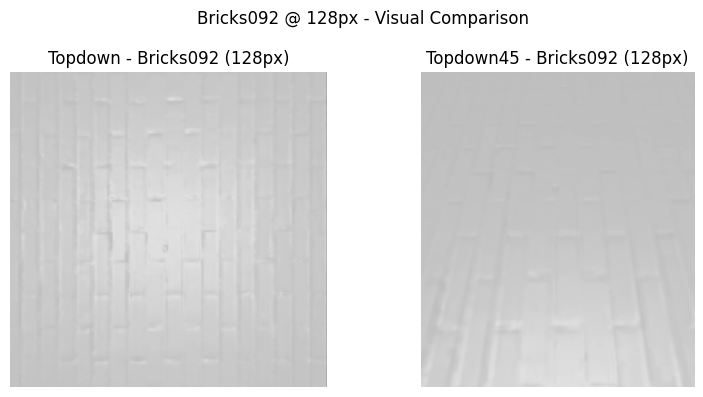

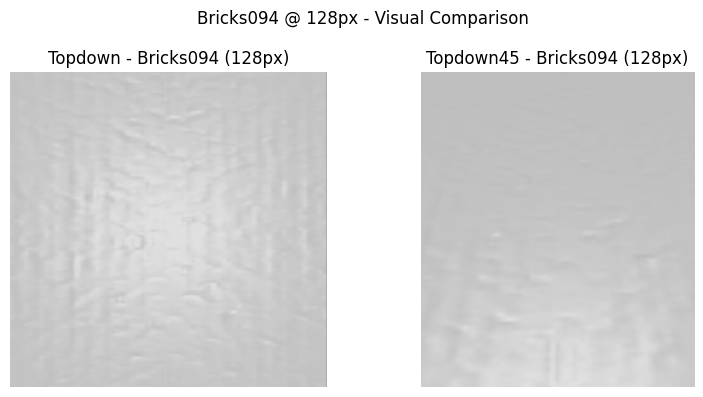

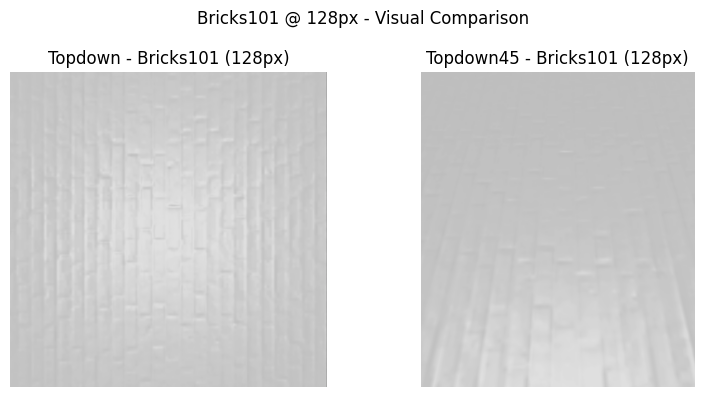

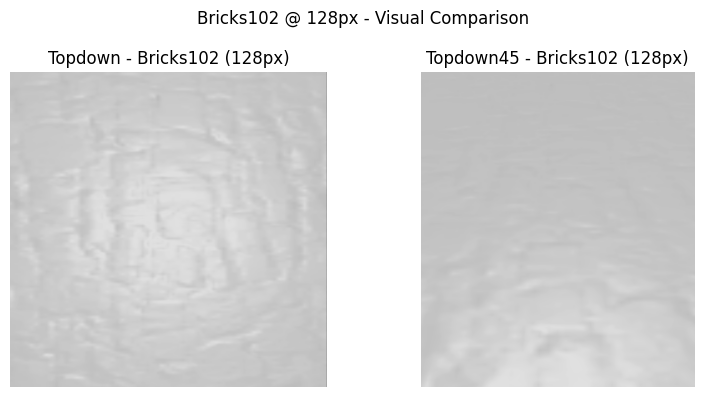

In [ ]:
for _, row in plot_order.iterrows():
    brick = row["Brick"]
    res = row["Resolution"]

    img_top = next((r for r in brick_images if brick in r["filename"] and f"_{res}" in r["filename"]), None)
    img_45 = next((r for r in brick45_images if brick in r["filename"] and f"_{res}" in r["filename"]), None)

    if img_top and img_45:
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(img_top["RGB"])
        axes[0].set_title(f"Topdown - {brick} ({res}px)")
        axes[0].axis("off")

        axes[1].imshow(img_45["RGB"])
        axes[1].set_title(f"Topdown45 - {brick} ({res}px)")
        axes[1].axis("off")

        plt.suptitle(f"{brick} @ {res}px - Visual Comparison", fontsize=12)
        plt.tight_layout()
        plt.show()
